## <center>Bangla Handwritten Math Solver<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()

print('Duration: {}'.format(start_time))

Duration: 2022-10-16 08:03:00.538705


## Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model

## Loading the Dataset 

In [3]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
div....
mul....
sub....
9062
9062
labels : ['3', 'sub', '5', 'add', '4', '2', '9', 'mul', '6', 'div', '1', '0', '8', '7']
Duration: 0:00:07.618342


## Visualizing Images in the Dataset 

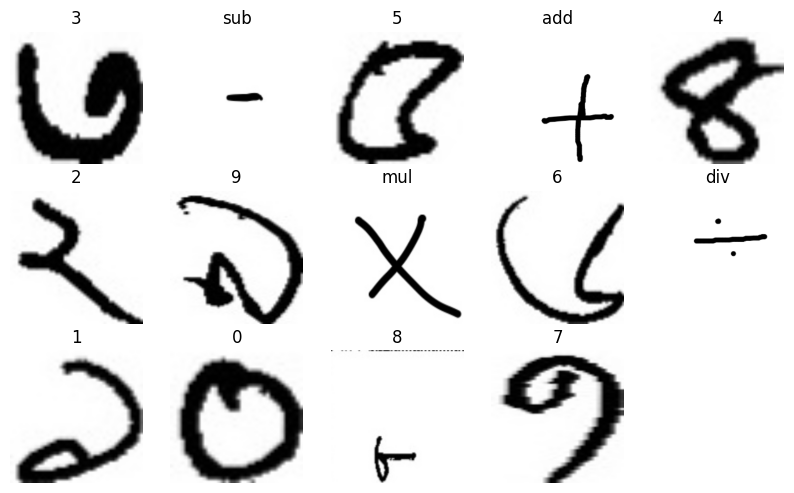

In [4]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

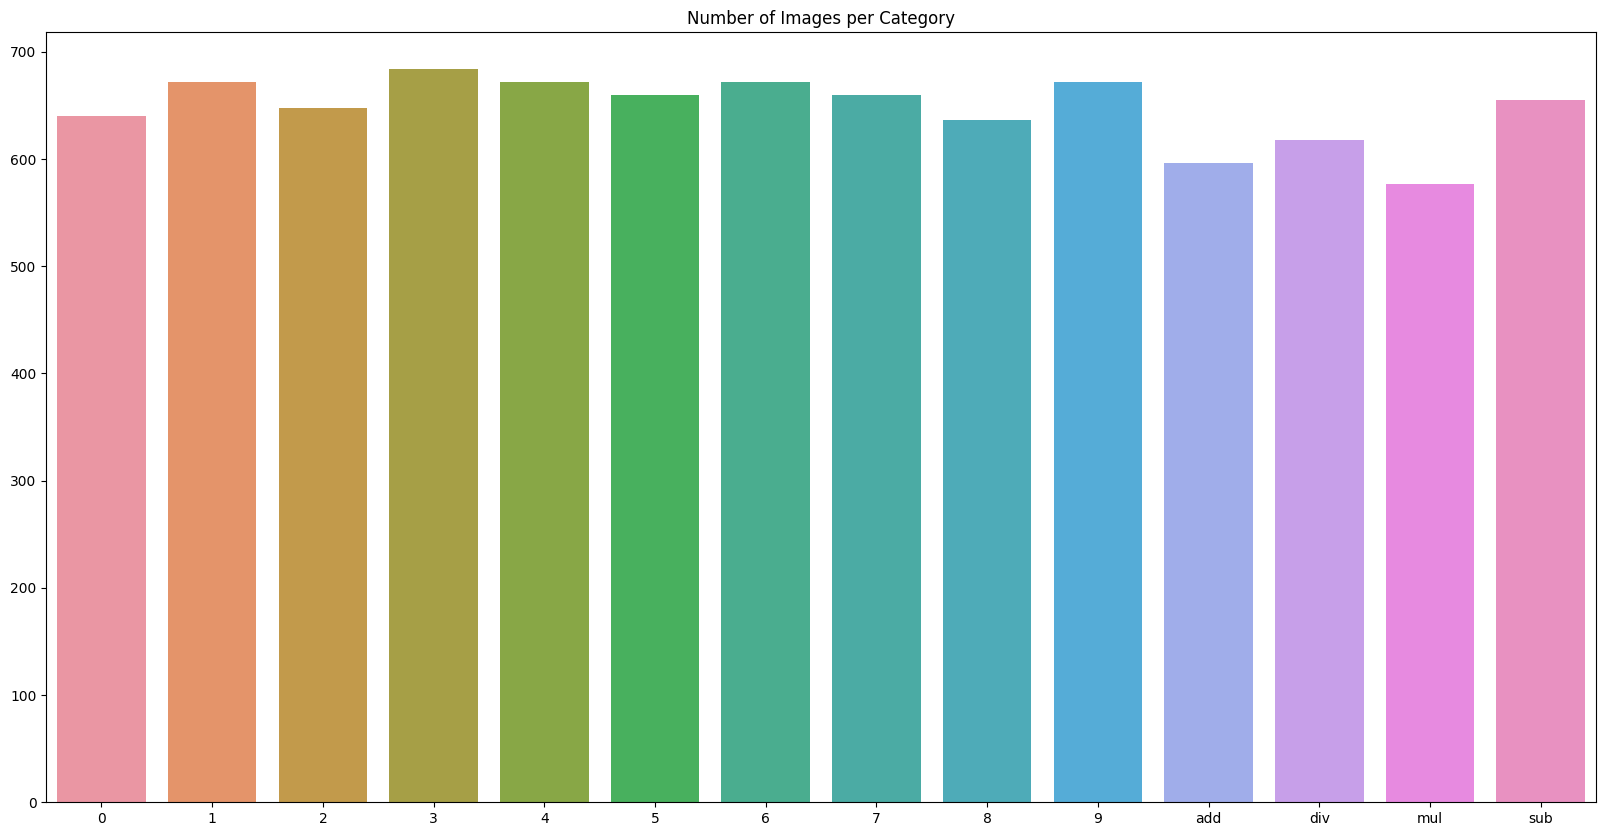

In [5]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [6]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [7]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9062
Duration: 0:00:09.006062


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9062
Duration: 0:00:09.032782


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

7249
1813
7249
1813


## Data Distribution in Train

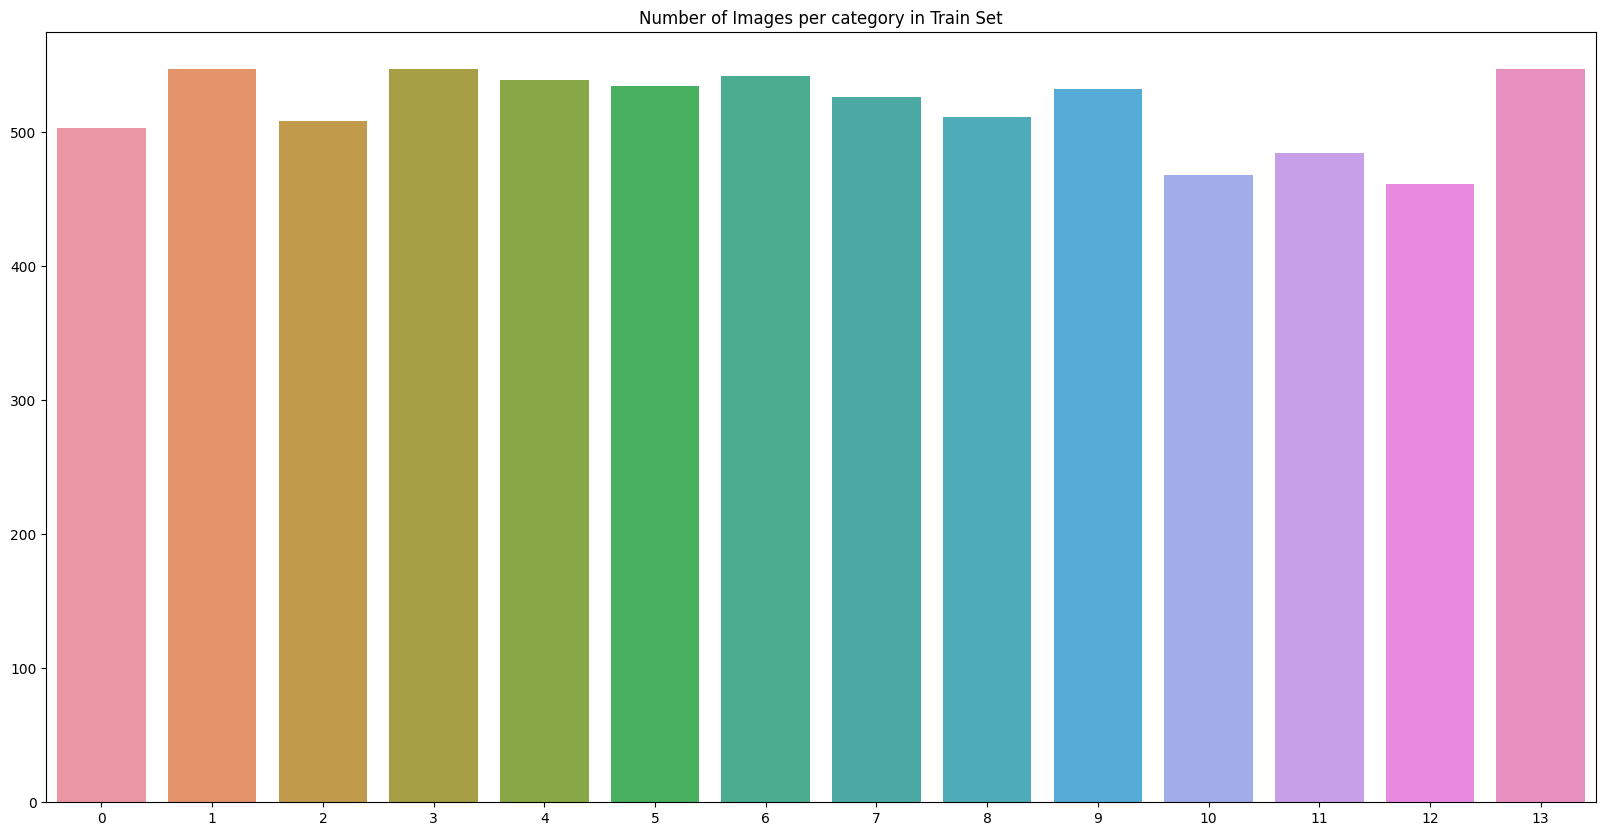

In [10]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

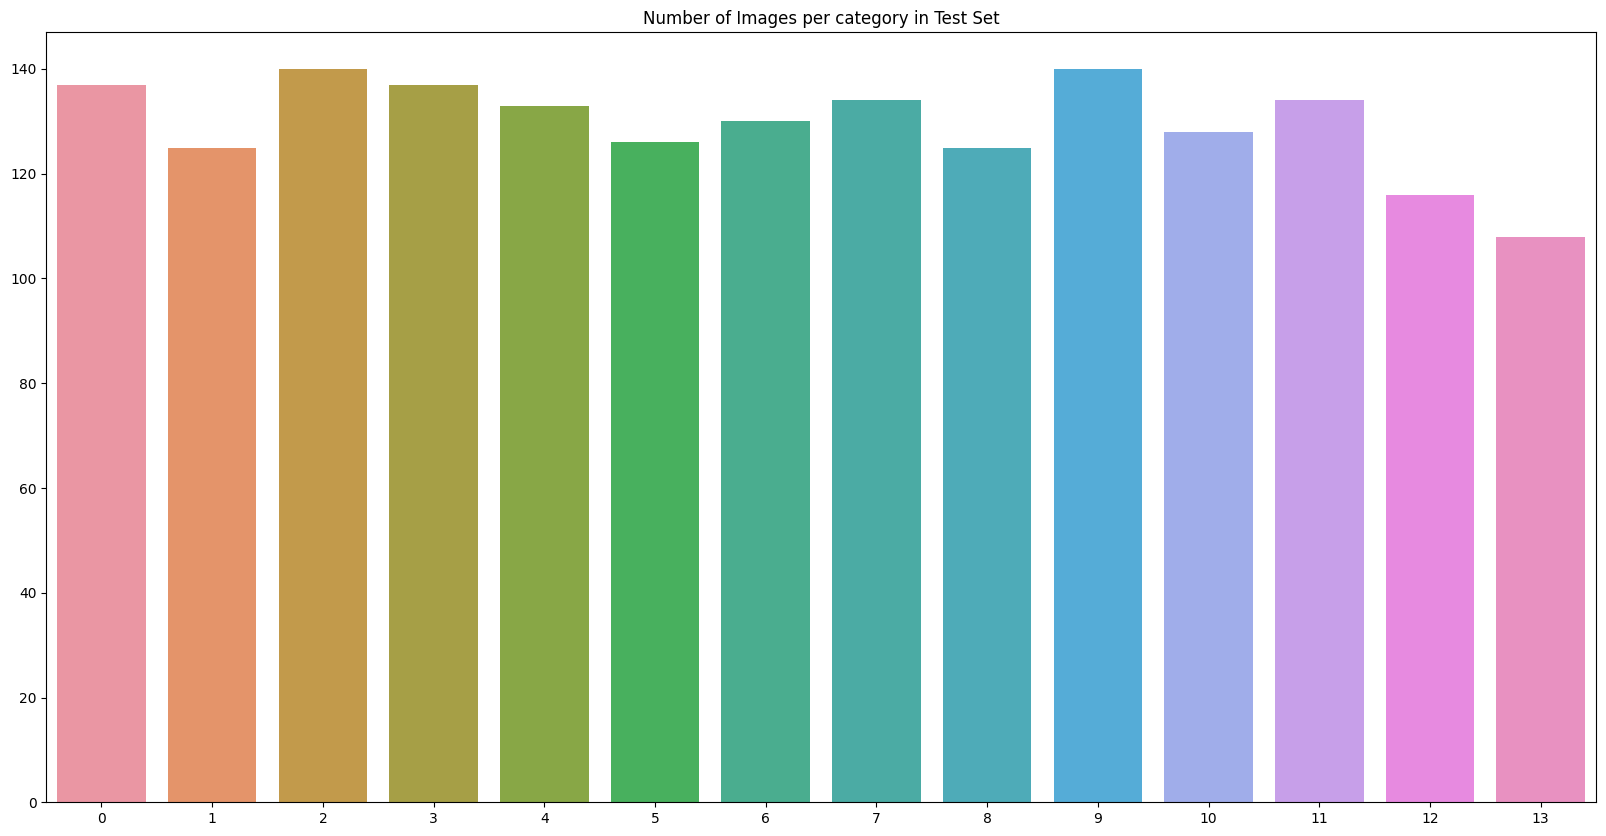

In [11]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7249, 32, 32, 1)
(1813, 32, 32, 1)
(7249, 14)
(1813, 14)


In [13]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:09.985421


In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
57/57 [==============================] - 6s 98ms/step - loss: 3.0290 - accuracy: 0.3594 - val_loss: 1.8026 - val_accuracy: 0.7380
Epoch 2/100
57/57 [==============================] - 6s 108ms/step - loss: 1.2208 - accuracy: 0.7638 - val_loss: 1.1168 - val_accuracy: 0.8020
Epoch 3/100
57/57 [==============================] - 7s 117ms/step - loss: 0.8662 - accuracy: 0.8237 - val_loss: 0.8610 - val_accuracy: 0.8478
Epoch 4/100
57/57 [==============================] - 7s 122ms/step - loss: 0.7200 - accuracy: 0.8462 - val_loss: 0.8120 - val_accuracy: 0.8560
Epoch 5/100
57/57 [==============================] - 7s 122ms/step - loss: 0.6190 - accuracy: 0.8676 - val_loss: 0.6933 - val_accuracy: 0.8798
Epoch 6/100
57/57 [==============================] - 8s 136ms/step - loss: 0.5683 - accuracy: 0.8746 - val_loss: 0.6171 - val_accuracy: 0.8969
Epoch 7/100
57/57 [==============================] - 7s 115ms/step - loss: 0.5135 - accuracy: 0.8896 - val_loss: 0.5990 - val_accuracy: 0.8864


Epoch 58/100
57/57 [==============================] - 6s 112ms/step - loss: 0.1452 - accuracy: 0.9694 - val_loss: 0.1910 - val_accuracy: 0.9603
Epoch 59/100
57/57 [==============================] - 6s 106ms/step - loss: 0.1355 - accuracy: 0.9721 - val_loss: 0.1887 - val_accuracy: 0.9608
Epoch 60/100
57/57 [==============================] - 6s 107ms/step - loss: 0.1395 - accuracy: 0.9694 - val_loss: 0.1615 - val_accuracy: 0.9686
Epoch 61/100
57/57 [==============================] - 6s 106ms/step - loss: 0.1380 - accuracy: 0.9690 - val_loss: 0.1676 - val_accuracy: 0.9675
Epoch 62/100
57/57 [==============================] - 6s 107ms/step - loss: 0.1275 - accuracy: 0.9739 - val_loss: 0.1697 - val_accuracy: 0.9675
Epoch 63/100
57/57 [==============================] - 6s 112ms/step - loss: 0.1277 - accuracy: 0.9732 - val_loss: 0.1732 - val_accuracy: 0.9686
Epoch 64/100
57/57 [==============================] - 6s 108ms/step - loss: 0.1237 - accuracy: 0.9738 - val_loss: 0.1654 - val_accuracy:

##  Loss and Accuracy Plot

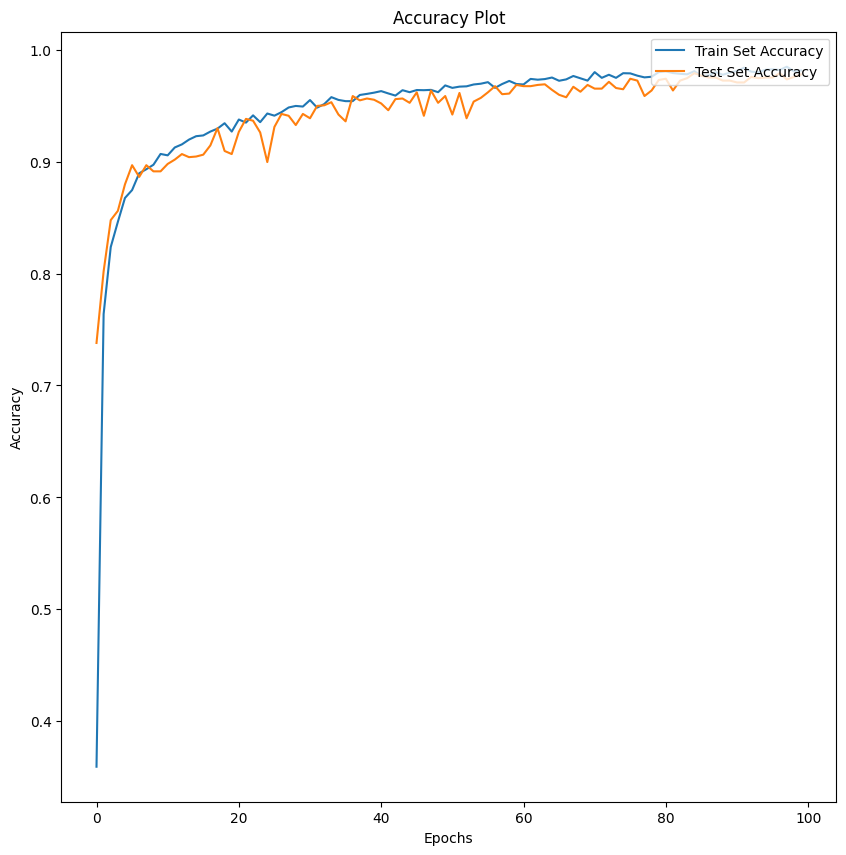

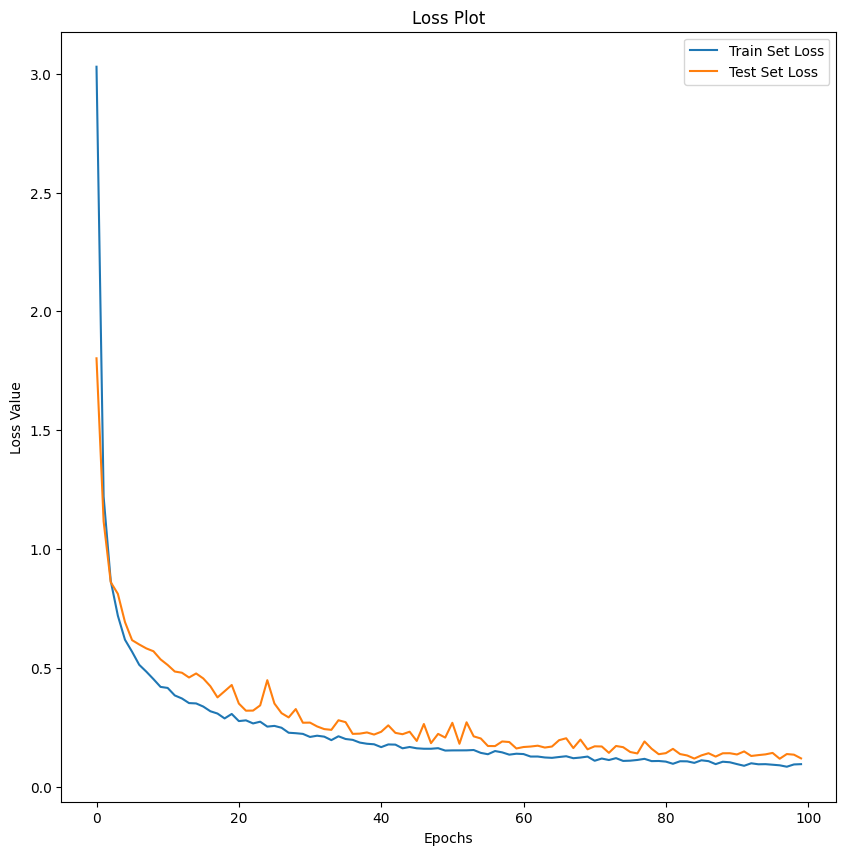

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

57/57 [==============================] - 1s 7ms/step


<AxesSubplot: >

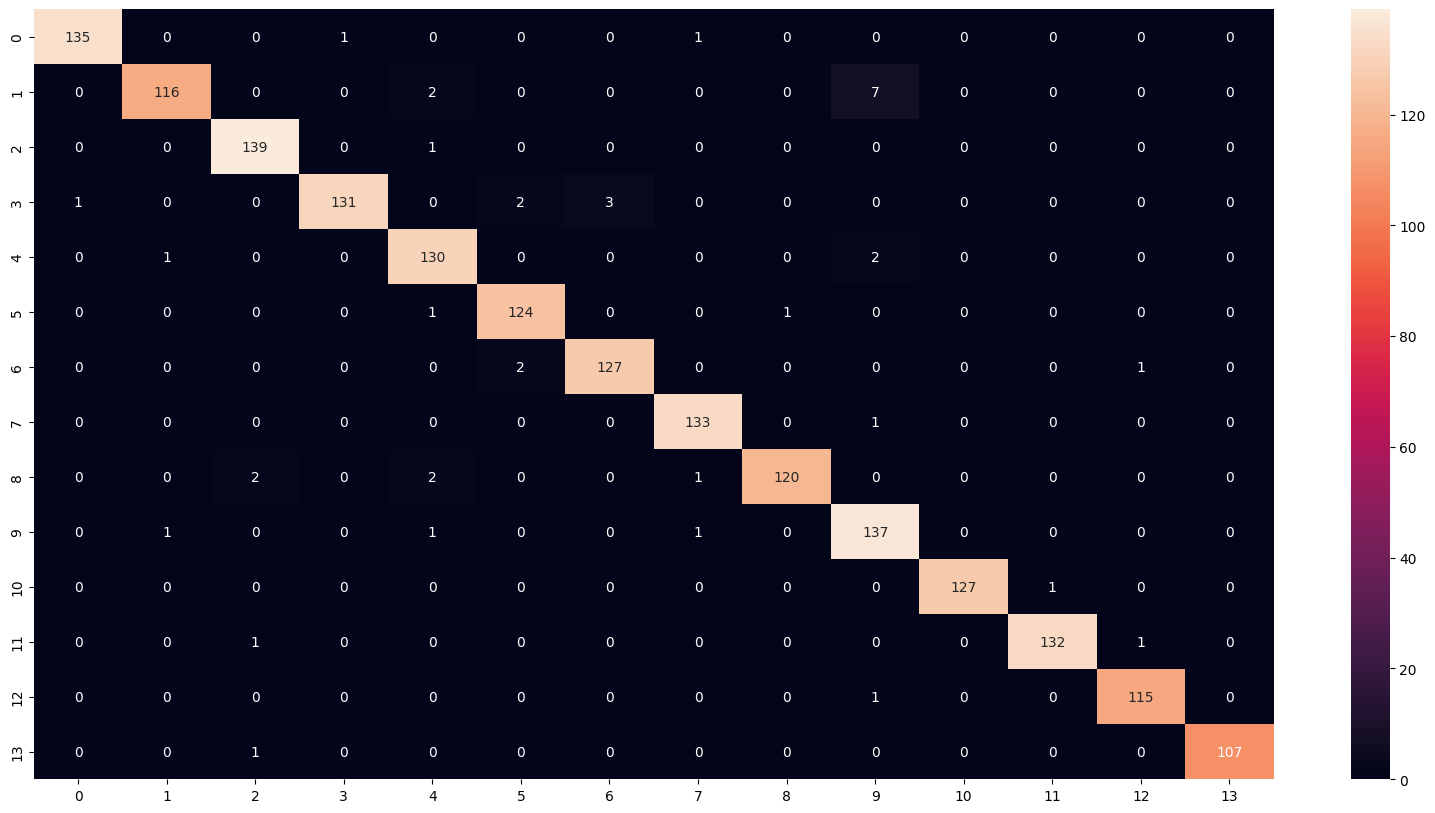

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [19]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.98      0.93      0.95       125
           2       0.97      0.99      0.98       140
           3       0.99      0.96      0.97       137
           4       0.95      0.98      0.96       133
           5       0.97      0.98      0.98       126
           6       0.98      0.98      0.98       130
           7       0.98      0.99      0.99       134
           8       0.99      0.96      0.98       125
           9       0.93      0.98      0.95       140
          10       1.00      0.99      1.00       128
          11       0.99      0.99      0.99       134
          12       0.98      0.99      0.99       116
          13       1.00      0.99      1.00       108

    accuracy                           0.98      1813
   macro avg       0.98      0.98      0.98      1813
weighted avg       0.98      0.98      0.98      1813



## Saving the Model 

In [20]:
model.save('math_symbol_and_digit_recognition.h5')

## Total Execution Time

In [21]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:10:46.218901


## Testing the Model 

In [22]:
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 17ms/step


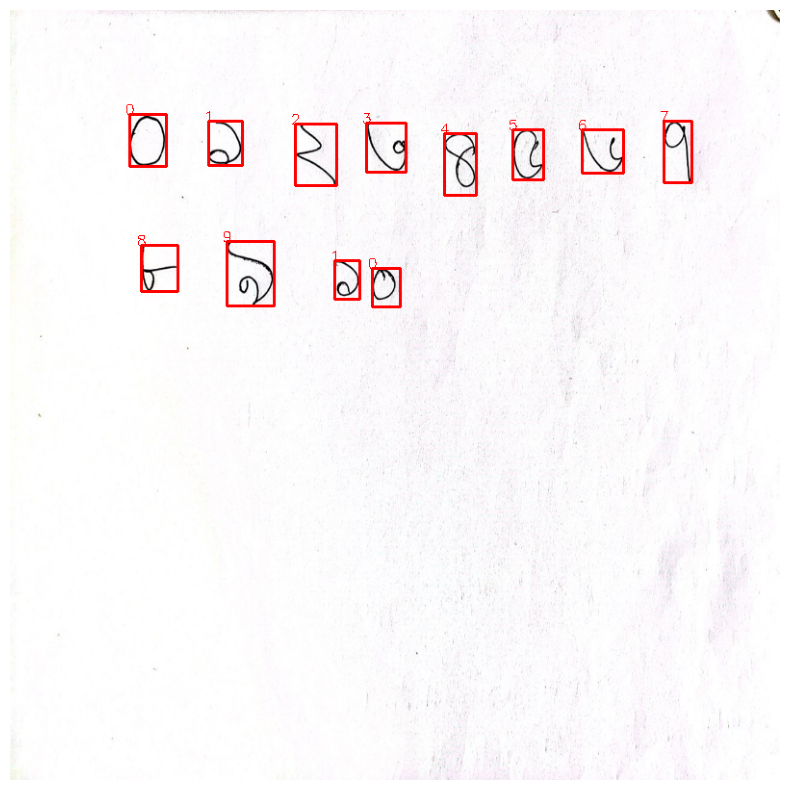

In [23]:
test_pipeline('test_data/test.jpg')

1/1 [==============================] - 0s 21ms/step


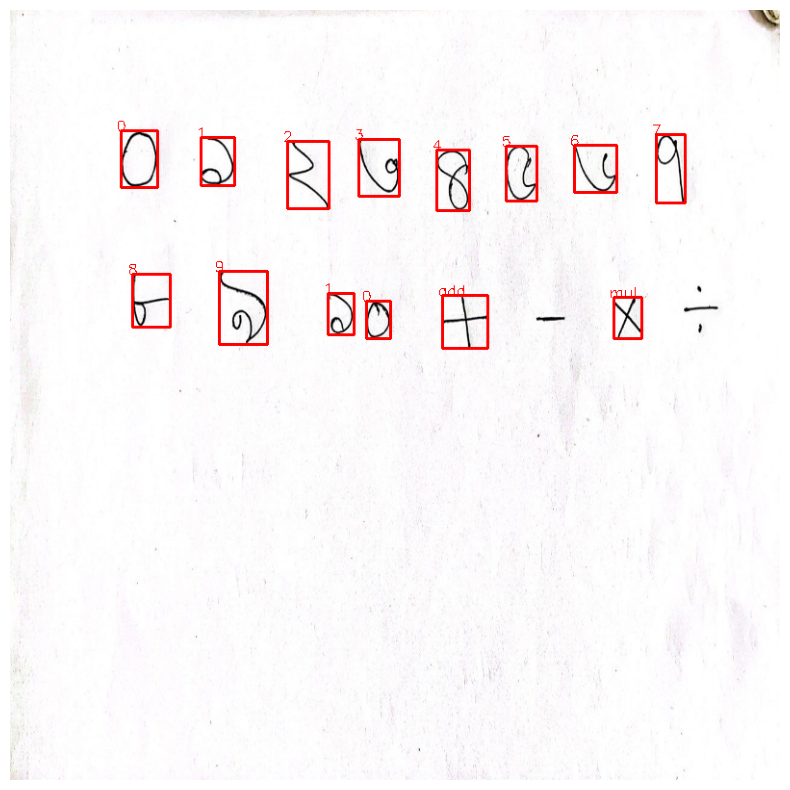

In [24]:
test_pipeline('test_data/test_2.jpg')

In [25]:
def test_pipeline_equation(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('V Result: {}', v)
    print('E Result: {}', e)
    print('Value of the expression {} : {}'.format(e, v)) 

1/1 [==============================] - 0s 33ms/step


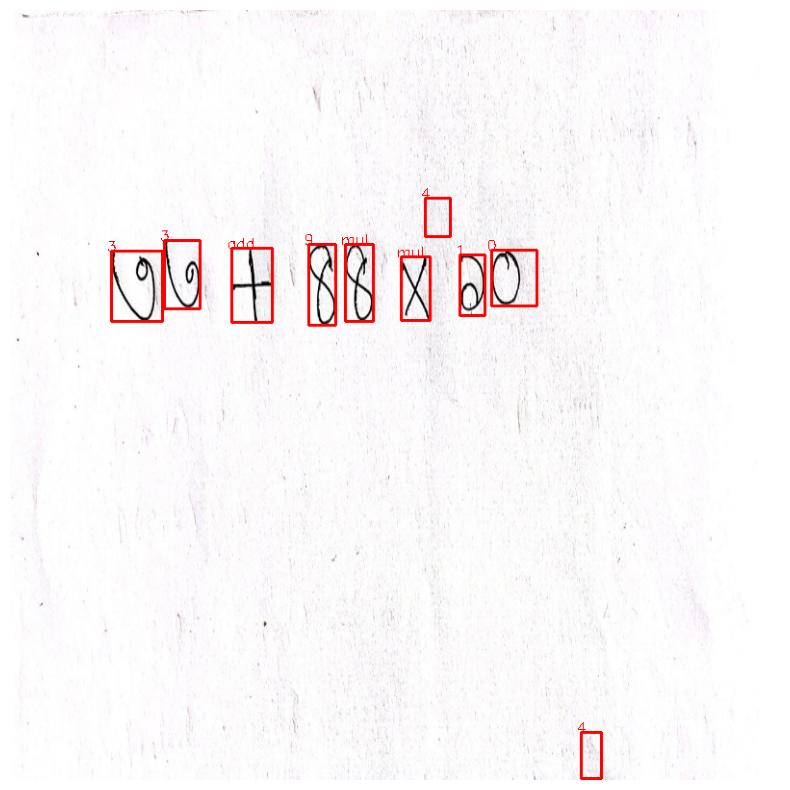

V Result: {} 162651749510247707820918824226675710553545984948549807719771396339313059986858255206434611653789584598511180401110775749591351376078945255186162757105186448984211749079635422491895573318290138208092515382713287157743256493785675067238875053715352768751995456923342676853325844208635329033654503026029299051772844521510032232780734964822743112661324951953096375675060957088342950537897038123603676768124856197539521079491070730356406620035394617849803240558722707101952004634823050014059930353426448276186662649733664894593599951445482606980613252806233133238807681385189233715540219718383464738011469355697096751568667090622040392708075373738301001855920027221108770861813514946781654474293638818644669415275037353349294098402209059636344005705448914385787678138065297753991536083960345108378626060391538194022852537654860132192096037427097273186258277802332250631620073095329205643380755387552783255381795169877319773078917790673356808282610533913761475696630044485541221389351359243395

In [26]:
test_pipeline_equation('test_data/test_equation_2.jpg')